# Figure 1: Adding a random dynamical nudge prevents a network from becoming polarized.

The time traces of $N=1000$ agents for (a) polarized ($\beta=3$) and (c) radicalized ($\beta=0$) states. (b, d) At $t = 10$, heat maps of agents' opinions versus mean of agents' nearest neighbours ($\langle x^{NN} \rangle$) to indicate the formation of echo chambers - agents interact with other agents who have similar opinions - and the resulting bimodal distribution of opinions for polarized networks. (e) $p_{opp}$ represents the probability of randomly flipping the homophily factor ($\beta$) to instead interact more with those holding opposite opinions. $p_{opp}$ did not appear to be effective and instead many simulations produced radicalized networks by $t=10$ (5 simulations individually plotted per $p_{opp}$). We introduce a "random dynamical nudge" (RDN, f) that prevents a network of agents from becoming polarized with sufficient strength $D$. The peak distance $\Lambda_x$ is shown by the width of the brace for each $D$. Here, the RDN is the Wiener process $\xi(t)$. The degree of polarization is indicated by the peak distance ($\Lambda_x$). Other simulation parameters were $m=10$, $K=3$, $\alpha=3$, and $r=0.5$.

## Imports and settings


If in a Colab notebook, this will

1. pull the latest version of `opinion_dynamics` from GitHub
1. add `opinion_dynamics` to path
2. mount your Google Drive (by asking for an authorization code)
3. make `.cache` and `.output` in your Google Drive under `My Drive > Colab Notebooks > opdynamics`
4. create symlinks between Colab's temporary local `.cache` and `.output` and the Google Drive folders for persistence

> Note:
>
> 1. Creating symlinks will fail when running the cell again. This is expected.


In [1]:
#@title Colab Setup { display-mode: "form" }
import sys

# for persisting data across sessions
connect_gdrive = False #@param {type:"boolean"}
cache_dir = ".cache" #param {allow-input: true}

try:
    from google.colab import drive

    # Clone github repository
    GIT_REPO = "https://github.com/ChrisCurrin/opinion_dynamics.git"
    !rm -rf ./temp
    !git clone --quiet "{GIT_REPO}" ./temp

    # add to path
    sys.path.append('./temp')
    # need latest tqdm version for tenumerate and tables to prevent HDF read error
    # !pip install -q --upgrade tqdm tables
    # !pip install -q --upgrade vaex IPython

    if connect_gdrive:
        # connect GDrive for retrieving/saving results
        drive.mount('/content/drive')

        # create symlink between a Drive folder and the cache for persistence between sessions
        import os
        try:
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/.cache")
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/output")
        except IOError:
            pass
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/.cache" ".cache"
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/output" "output"

except ModuleNotFoundError:
    print(f"local notebook on {sys.platform}")
    pass

local notebook on win32


In [2]:
#@title Imports and settings { display-mode: "form" }
%reload_ext autoreload
%autoreload 2

import logging
import itertools
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
from matplotlib.cbook import flatten
from matplotlib.collections import PolyCollection

try:
    import opdynamics.simulation as Simulation
except AttributeError:
    raise RuntimeError("restart runtime")
from opdynamics.socialnetworks import (SocialNetwork, ConnChamber, ContrastChamber, OpenChamber, SampleChamber)
from opdynamics.visualise import (VisSocialNetwork,
                                  show_K_alpha_phase,
                                  show_activity_vs_opinion,
                                  show_jointplot,
                                  show_noise_panel,
                                  show_opinion_grid,
                                  )
from opdynamics.metrics.opinions import calc_distribution_differences, distribution_modality
from opdynamics.visualise import plot_surface_product, plot_surfaces
from opdynamics.utils.distributions import negpowerlaw
from opdynamics.utils.plot_utils import df_multi_mask, move_cbar_label_to_title
from opdynamics.utils.cache import get_cache_dir, set_cache_dir, process_cache_arg
from opdynamics.utils.logging import LoggingContext
from opdynamics.utils.constants import *
from opdynamics.visualise.compat import sns_kdeplot

try:
    os.makedirs("output")
except FileExistsError:
    pass

old_cache_dir, new_dir = set_cache_dir(cache_dir)

np.random.seed(1337)
sns.set_theme(context="notebook", style="ticks",
        rc={
            "pdf.fonttype": 42, # embed font in output
            "svg.fonttype": "none",  # embed font in output
            # "figure.facecolor":"white",
            "axes.facecolor": "None",
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            }
        )
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
plt.style.use("dark_background")
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("asyncio").setLevel(logging.WARNING)

C:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Figure 1

> The convenient `Simulation.run_params` static method is used.


In [3]:
# General params
N = 1000
m = 10
T = 10
epsilon = 1e-2
gamma = 2.1
r = 0.5  # probability of mutual interaction
dt = 0.01
activity_distribution = negpowerlaw

# Specific params for different dynamics
param_set = {
    "neutral": dict(K=3, alpha=0.05, beta=2),
    "radical": dict(K=3, alpha=3, beta=0),
    "polar": dict(K=3, alpha=3, beta=3),
}


## Neutral opinion (not shown)

Low controversialness

- $K = 3$
- $\alpha = 0.05$
- $\beta = 2$


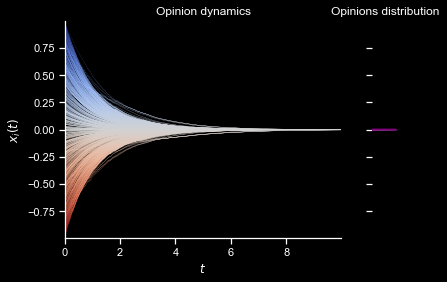

In [4]:
ec_neutral = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    **param_set["neutral"],
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=True,
    cache="all"
)


## Polarisation of opinions

Strong social interactions ($K$), controversial issue ($\alpha$), and greater chance of connecting with people with similar opinions ($\beta$)

- $K = 3$
- $\alpha = 3$
- $\beta = 3$


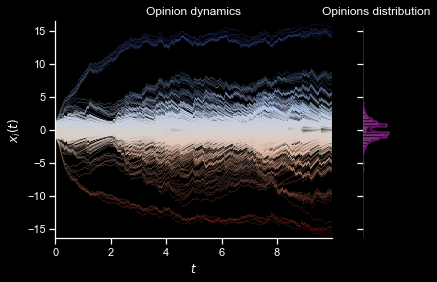

In [5]:
ec_polar = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    **param_set["polar"],
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=True,
    cache="all",
    seed=10001,
)
# plt.savefig("output/fig1a.svg")

running D=0.0
running c:\Users\ccurrin\dev\opinion_dynamics\.cache\sn_polar_D0.00_[1337].h5


C:\Users\ccurrin\AppData\Local\Temp\ipykernel_21700\345130160.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_df = x_df.append(tmp_df, ignore_index=True)


running D=0.0
running c:\Users\ccurrin\dev\opinion_dynamics\.cache\sn_polar_D0.00_[16029].h5


C:\Users\ccurrin\AppData\Local\Temp\ipykernel_21700\345130160.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_df = x_df.append(tmp_df, ignore_index=True)


running D=0.0
running c:\Users\ccurrin\dev\opinion_dynamics\.cache\sn_polar_D0.00_[712406].h5


C:\Users\ccurrin\AppData\Local\Temp\ipykernel_21700\345130160.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_df = x_df.append(tmp_df, ignore_index=True)


running D=3.0
running c:\Users\ccurrin\dev\opinion_dynamics\.cache\sn_polar_D3.00_[1337].h5


C:\Users\ccurrin\AppData\Local\Temp\ipykernel_21700\345130160.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_df = x_df.append(tmp_df, ignore_index=True)


running D=3.0
running c:\Users\ccurrin\dev\opinion_dynamics\.cache\sn_polar_D3.00_[16029].h5


C:\Users\ccurrin\AppData\Local\Temp\ipykernel_21700\345130160.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_df = x_df.append(tmp_df, ignore_index=True)


running D=3.0
running c:\Users\ccurrin\dev\opinion_dynamics\.cache\sn_polar_D3.00_[712406].h5


C:\Users\ccurrin\AppData\Local\Temp\ipykernel_21700\345130160.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_df = x_df.append(tmp_df, ignore_index=True)


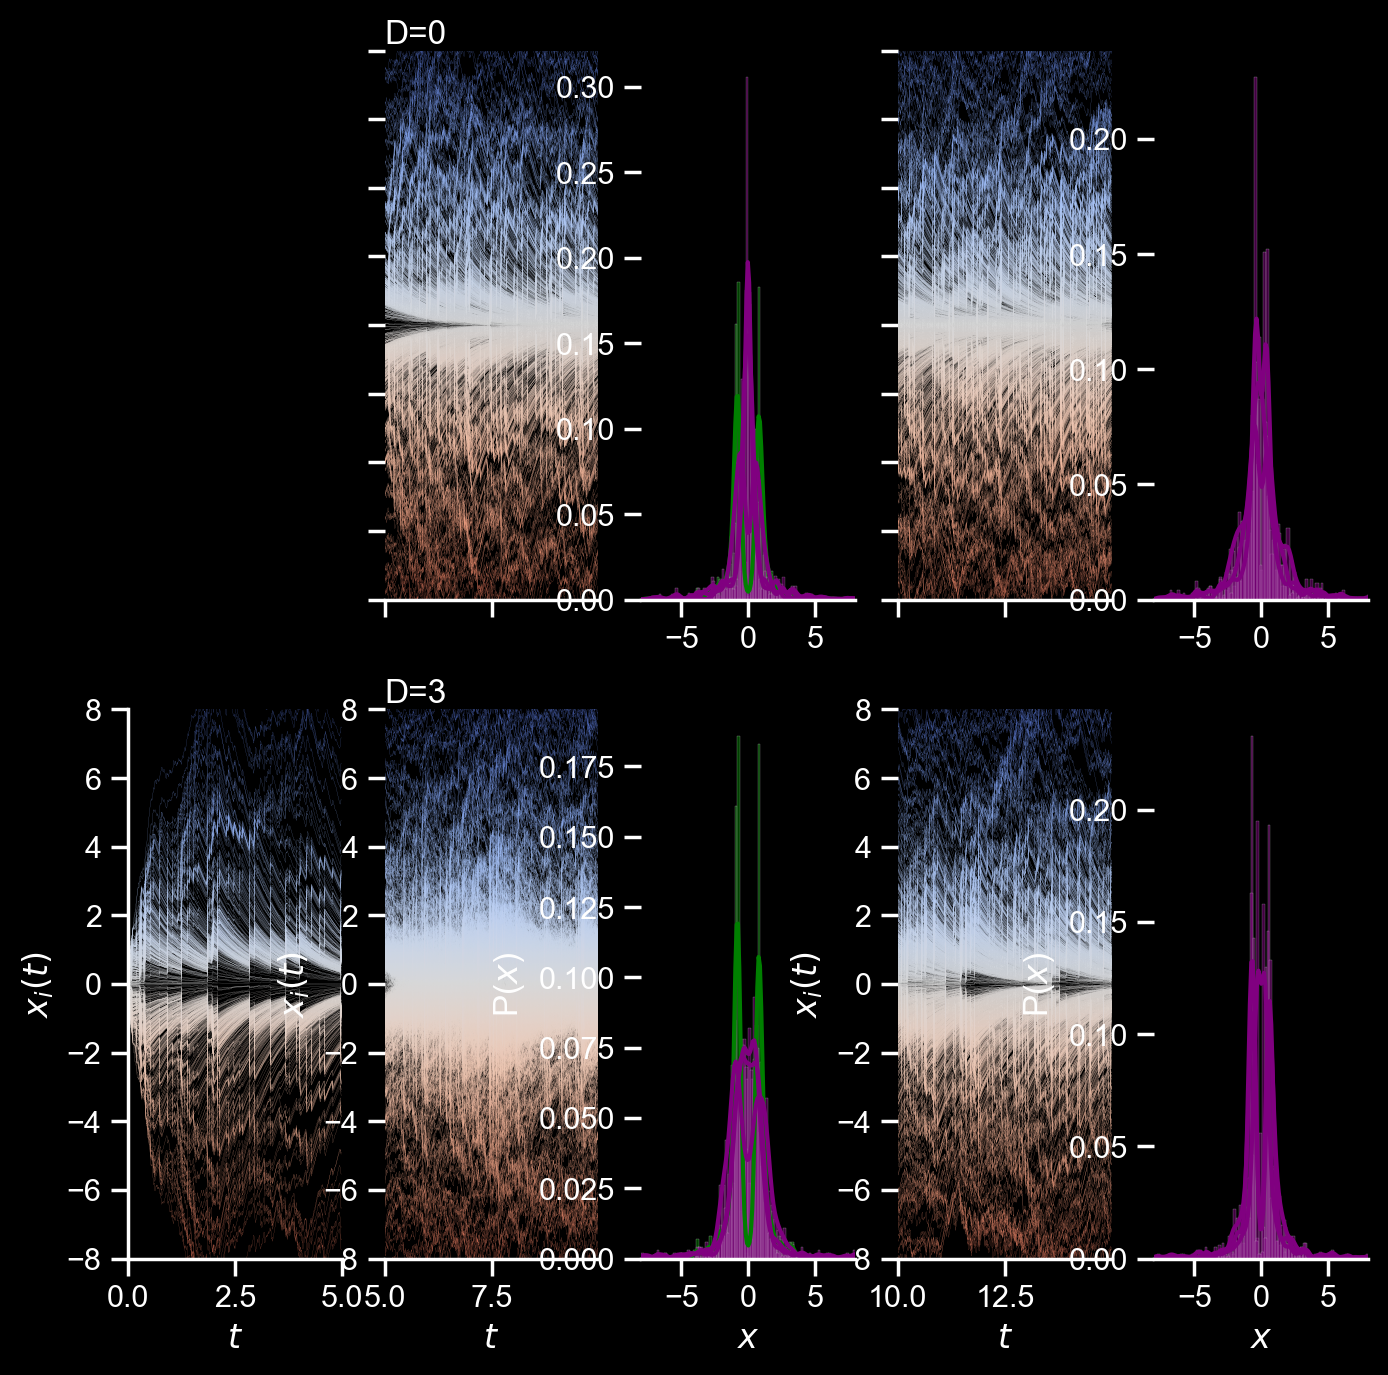

In [6]:
T = 5.0
method = "RK45"
dt = 0.01
cache = "all"

D_range = [0.0, 3.0]
plt.rcParams["figure.dpi"] = 200
fig, axes = plt.subplot_mosaic(
    [
        [
            "time" if i == len(D_range) // 2 else ".",
            f"D panel {i}",
            f"distribution{i}",
            f"recovery{i}",
            f"distribution{i}recover",
        ]
        for i in range(len(D_range))
    ],
    figsize=(8, 8),
)

bins = 100
hist_kwargs = dict(
    title=False,
    vertical=False,
    alpha=0.5,
    bins=bins,
    kde=True,
    kde_kws=dict(bw_adjust=0.5),
    rasterized=True,
)
line_kwargs = dict(lw=0.05)
ylim = (-8, 8)

other_seeds = [1337, 16029, 712406]
time_points = [T, T * 2, T * 3]
x_df = pd.DataFrame(columns=["i", "D", "seed", OPINION_SYMBOL, "t"])
agent_idxs = list(range(N))

for i, D in enumerate(D_range):
    ax_opinion = axes[f"D panel {i}"]
    ax_dist = axes[f"distribution{i}"]
    ax_recovery = axes[f"recovery{i}"]
    ax_dist_recovery = axes[f"distribution{i}recover"]
    for s, seed in enumerate(other_seeds):
        with LoggingContext(logging.INFO):
            print(f"running D={D}")
            sn_polar = Simulation.run_params(
                SampleChamber,
                filename="sn_polar",
                N=N,
                m=m,
                **param_set["polar"],
                activity=activity_distribution,
                epsilon=epsilon,
                gamma=gamma,
                r=r,
                dt=dt,
                T=T,
                plot_opinion=False,
                method=method,
                D=0,
                cache=cache,
                seed=1337,
            )

            vis = VisSocialNetwork(sn_polar)

            if i == 0 and s == 0:
                vis.show_opinions(
                    ax=axes["time"],
                    color_code="line",
                    rasterized=True,
                    title=False,
                    **line_kwargs,
                )
                axes["time"].set(
                    xlim=(0, T),
                    ylim=ylim,
                )
            if s == 0:
                vis.show_opinions_distribution(
                    t=T, ax=ax_dist, color="Green", **hist_kwargs
                )

            sn_polar.filename = f"sn_polar_D{D:.2f}_[{seed}]"
            print(f"running {sn_polar.filename}")

            sn_polar.seed = seed

            if not (cache and sn_polar.load(dt, T * 2)):
                sn_polar.set_dynamics(D=D)
                sn_polar.run_network(dt, T, method=method)
                if cache:
                    sn_polar.save(*process_cache_arg(cache), write_mapping=False)

            vis.show_opinions(
                ax=ax_opinion,
                color_code="line",
                rasterized=True,
                title=False,
                **line_kwargs,
            )

            vis.show_opinions_distribution(ax=ax_dist, **hist_kwargs)

            sn_polar.filename = f"sn_polar_D{D:.2f}_recover[{seed}]"
            # turn off D
            if not (cache and sn_polar.load(dt, T * 3)):
                sn_polar.set_dynamics(D=0)
                sn_polar.run_network(dt, T, method=method)
                if cache:
                    sn_polar.save(*process_cache_arg(cache), write_mapping=False)

            vis.show_opinions(
                ax=ax_recovery,
                color_code="line",
                rasterized=True,
                title=False,
                **line_kwargs,
            )

            vis.show_opinions_distribution(ax=ax_dist_recovery, **hist_kwargs)

            for t in time_points:
                tmp_df = pd.DataFrame(
                    {
                        OPINION_SYMBOL: sn_polar.opinions_at_t(t)[-1],
                        "t": t,
                        "i": sn_polar.agent_idxs,
                        "D": D,
                        "seed": seed,
                    }
                )
                x_df = x_df.append(tmp_df, ignore_index=True)

    sns.despine(ax=ax_dist, left=True)
    sns.despine(ax=ax_opinion, left=True)
    sns.despine(ax=ax_dist_recovery, left=True)
    sns.despine(ax=ax_recovery, left=True)
    # axes[1,i].axvline(x=T, color="k", linestyle="--")
    if i < len(D_range) - 1:
        ax_opinion.set(xlabel="", ylabel="", yticklabels=[], xticklabels=[])
        ax_recovery.set(xlabel="", ylabel="", yticklabels=[], xticklabels=[])
        ax_dist.set(xlabel="", ylabel="")
        ax_dist_recovery.set(xlabel="", ylabel="")
    ax_dist.set(xlim=ylim)
    ax_dist_recovery.set(xlim=ylim)
    ax_opinion.set(ylim=ylim)
    ax_opinion.set_xlim(left=T)
    ax_recovery.set(ylim=ylim)
    ax_recovery.set_xlim(left=T * 2)
    ax_opinion.set_title(f"D={D:.0f}", va="top", loc="left")


ValueError: object arrays are not supported

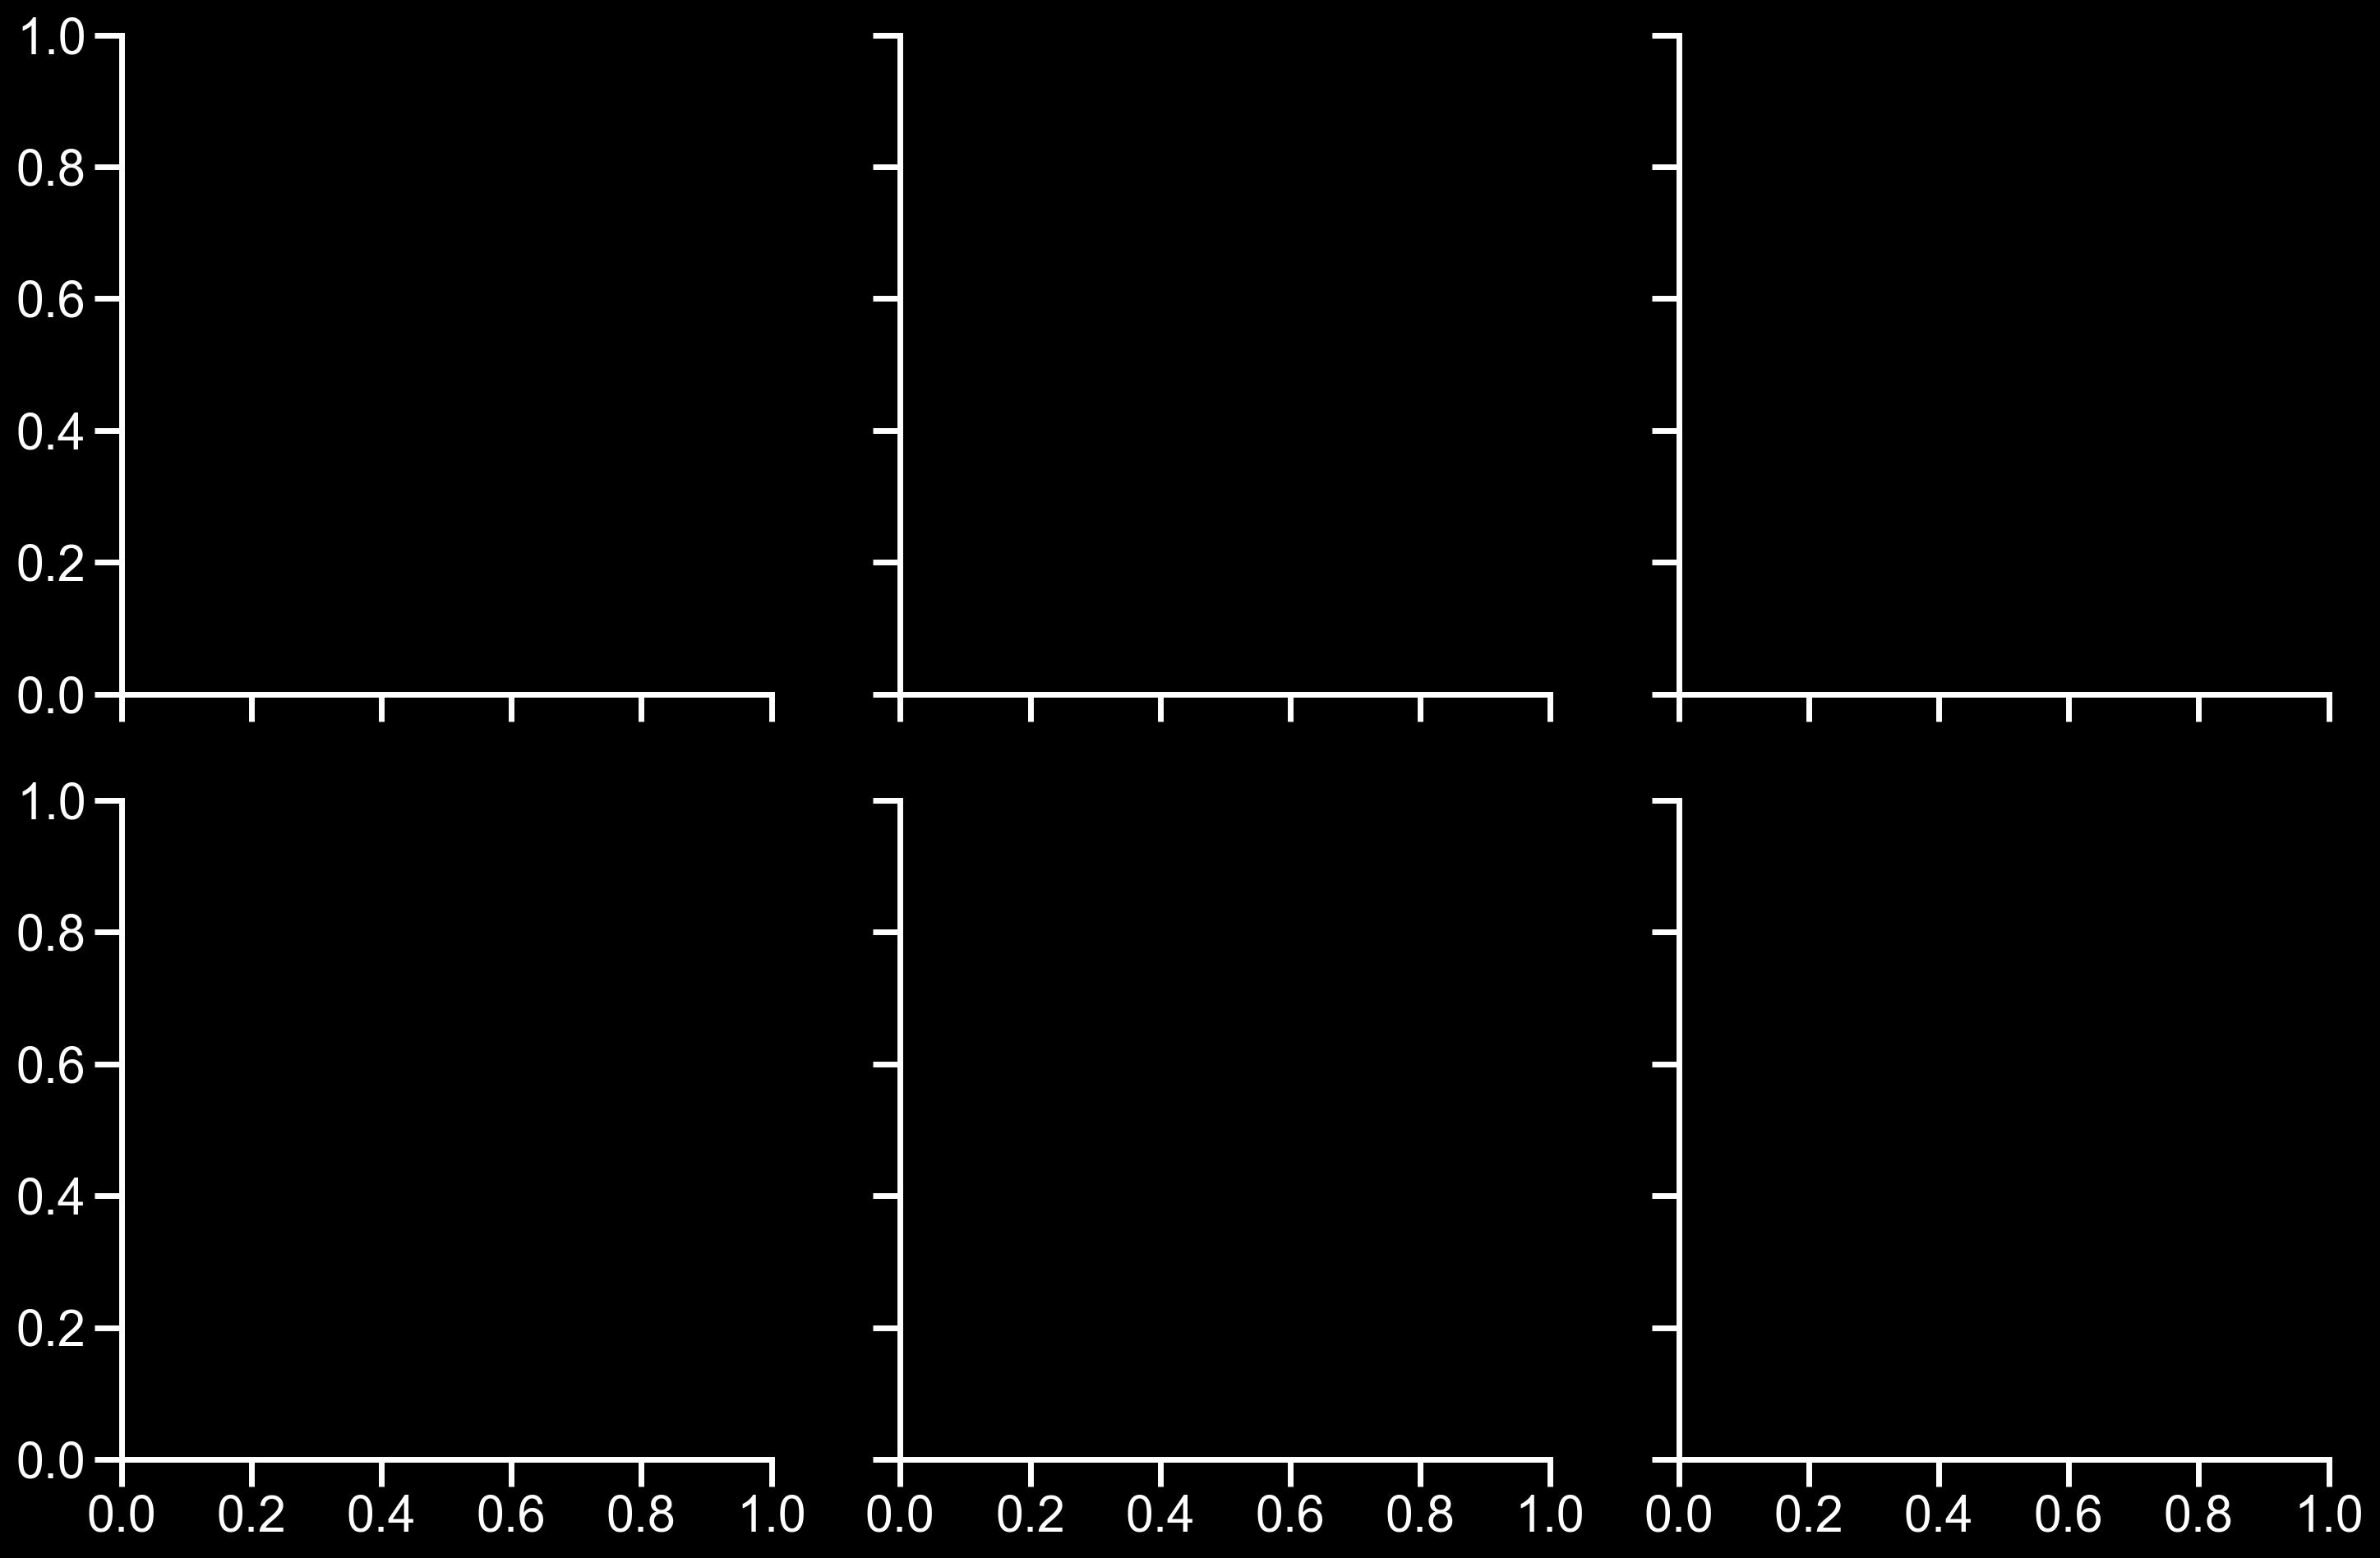

In [7]:
with sns.plotting_context("poster", rc={"figure.dpi": 400}):
    g = sns.displot(
        data=x_df,
        x=OPINION_SYMBOL,
        hue="D",
        col="t",
        row="D",
        kind="kde",
        fill=True,
        bw_adjust=0.1,
    )
    g.set(xlim=(-5, 5))


## **c**) Radicalisation of opinions

Uniform connection probabilities

- $K = 3$
- $\alpha = 3$
- $\beta = 0$


In [ ]:
ec_radical = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    **param_set["radical"],
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=True,
    cache="all"
)


_for moderate $\beta$, a polarised network may turn radical._


In [ ]:
T = 20
ec_polar_radical = Simulation.run_params(
    SocialNetwork,
    N=N,
    m=m,
    K=3,
    alpha=3,
    beta=0.6,
    activity=activity_distribution,
    epsilon=epsilon,
    gamma=gamma,
    r=r,
    dt=dt,
    T=T,
    plot_opinion=False,
    cache="all",
)
vis = VisSocialNetwork(ec_polar_radical)
fig, axs = plt.subplots(2, 2, sharex="row", sharey=False)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
fig.subplots_adjust(hspace=0.3)
vis.show_opinions(color_code="line", subsample=2, lw=1, ax=axbig)
vis.show_opinions_distribution(
    t=5.0, ax=axs[1, 0], kde_kws=dict(bw_adjust=0.1), fill=True, title=f"5"
)
vis.show_opinions_distribution(ax=axs[1, -1], fill=True, title=f"{T}")


## **b** and **d**) Nearest Neighbour


In [ ]:
vis = VisSocialNetwork(ec_polar)

levels = 10

fig, ax_joint, ax_marg_x, ax_marg_y = vis.show_nearest_neighbour(
    bw_adjust=0.5,
    color=sns.cubehelix_palette(levels, reverse=True)[levels // 2],
    cmap=sns.cubehelix_palette(levels, reverse=True, as_cmap=True),
    levels=levels,
    shade_lowest=True,
)
lim = (-5, 5)
ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
ax_joint.set_ylim(*lim)

## **e**) Dynamic connections


| Symbol      | Keyword | Class (inherits from)        | Meaning                                                      | Range ($\mathbb{R}$) |
| ----------- | ------- | ---------------------------- | ------------------------------------------------------------ | -------------------- |
| $P(-\beta)$ | `p_opp` | `ConnChamber(SocialNetwork)` | Probability of interacting with an agent of opposing opinion | $[0,1]$              |


In [ ]:
# @title Dynamic connections { run: "auto", vertical-output: true }

# polar opinions
N = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # @param {type:"slider", min:0, max:3, step:0.5}
r = 0.5  # probability of a mutual interaction
activity_distribution = negpowerlaw
dt = 0.01
T = 10
seed = 1001
p_opp = 0.5  # @param {type:"slider", min:0, max:1, step:0.05}
with LoggingContext(logging.INFO):
    cc = Simulation.run_params(
        ConnChamber,
        N=N,
        m=m,
        K=K,
        alpha=alpha,
        beta=beta,
        activity=activity_distribution,
        epsilon=epsilon,
        gamma=gamma,
        r=r,
        dt=dt,
        T=T,
        p_opp=p_opp,
        seed=seed,
        name=f"p_opp={p_opp}, seed={seed}",
        cache="all",
        method="RK45",
        plot_opinion=False,  # gets plotted better below
    )

with sns.plotting_context():
    vis = VisSocialNetwork(cc)
    fig, ax = plt.subplots(
        2, 2, figsize=(4, 8), gridspec_kw=dict(width_ratios=[1, 0.1])
    )
    vis.show_opinions(ax=ax[0, 0])
    fig.subplots_adjust(wspace=0.1, hspace=0.5)
    vis.show_opinions_distribution(
        ax=ax[0, 1], vertical=True, kde_kws=dict(bw_adjust=0.1)
    )
    vis.show_adjacency_matrix(
        "mesh",
        sort=True,
        cmap=sns.cubehelix_palette(light=1, as_cmap=True),
        cbar_kws=dict(pad=0.05, cax=ax[1, 1]),
        ax=ax[1, 0],
    )
    # vis.show_connection_probabilities("mesh", sort=True,
    #                                   cmap=sns.cubehelix_palette(light=1, as_cmap=True),
    #                                   cbar_kws=dict(pad=0.05, cax=ax[1,1]),
    #                                   ax=ax[1,0])
    # move_cbar_label_to_title(ax[1,1])
    for _ax in ax[0, :]:
        _ax.set_ylim(-5, 5)
    sns.despine()
    sns.despine(ax=ax[0, 1], left=True)
    ax[0, 1].set_ylabel("")
    ax[0, 1].set_yticks([])
    fig.suptitle(f"p_opp={p_opp}")
    fig.set_facecolor("w")


In [ ]:
P_OPP = "$p_{opp}$"
p_opps = np.round(np.arange(0, 1.01, 0.1), 2)
seeds = [
    1270771659,
    1625290209,
    548458026,
    2384583708,
    2387812158,
    686114197,
    788951673,
    3299294382,
    1039135244,
    4130642021,
]

kwargs = dict(
    N=1000,
    m=10,
    activity_distribution=negpowerlaw,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    T=10,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
)

range_vars = {
    "p_opp": {"range": p_opps, "title": P_OPP},
    "seed": {"range": seeds},
    "beta": {"range": [3], "title": "beta"},
}

set_cache_dir(cache_dir)
with LoggingContext(logging.INFO):
    p_opp_df = Simulation.run_product(
        range_vars,
        cls=ConnChamber,
        cache=True,  # save just end points, not full evolution
        cache_sim="p_opp",
        method="RK45",
        parallel=5,
        **kwargs
    )
p_opp_df


In [ ]:
def plot_p_opp_density(
    p_opp_df, run_p_opps=None, betas=None, axes=None, save=False, subplot_adjust=None
):
    if run_p_opps is None:
        run_p_opps = sorted(p_opp_df["p_opp"].unique())

    if axes is None:
        fig, axes = plt.subplots(
            len(run_p_opps), figsize=(5, 7), sharex=False, sharey=True
        )
    else:
        fig = axes[0].figure

    bw_adjust = 0.5

    pd_p_opp = p_opp_df.to_pandas_df().rename(
        columns={"p_opp": P_OPP, "opinion": OPINION_SYMBOL}
    )

    if betas is None:
        betas = p_opp_df["beta"].unique()
    else:
        pd_p_opp = pd_p_opp[pd_p_opp["beta"].isin(betas)]

    if len(betas) > 1:
        hue = "beta"
        hue_order = betas
    else:
        hue = "seed"
        hue_order = sorted(p_opp_df["seed"].unique())

    # more colors for blending
    pal = sns.color_palette("icefire", n_colors=len(run_p_opps) * 2 + 1)

    for i, p_opp in enumerate(run_p_opps):
        sns.kdeplot(
            data=pd_p_opp[pd_p_opp[P_OPP] == p_opp],
            x=OPINION_SYMBOL,
            hue=hue,
            hue_order=hue_order,
            ax=axes[i],
            palette=sns.blend_palette(
                [pal[i * 2], pal[i * 2 + 1]], n_colors=len(hue_order), input="hex"
            ),
            bw_adjust=bw_adjust,
            clip_on=False,
            fill=True,
            alpha=0.5,
            linewidth=1.5,
            edgecolor="w",
            legend=False,
            zorder=100,
        )
        axes[i].set(ylabel="", yticks=[], yticklabels=[], xlim=(-5, 5))

        axes[i].text(
            0,
            0.2,
            f"{p_opp}",
            fontweight="bold",
            color=pal[i * 2],
            ha="right",
            va="center",
            transform=axes[i].transAxes,
        )

        if i < len(run_p_opps) - 1:
            axes[i].set(xticks=[], xlabel="")
    if subplot_adjust:
        fig.subplots_adjust(hspace=subplot_adjust)
    # fig.subplots_adjust(hspace=0.01)
    for ax in axes:
        sns.despine(ax=ax, left=True, bottom=True)

    axes[0].set(xlim=(-5, 5))
    if save:
        fig.savefig(f"output/p_opp_{save}", transparent=True)


with sns.plotting_context("poster"):
    plt.rcParams["axes.facecolor"] = "None"
    plot_p_opp_density(
        p_opp_df,
        run_p_opps=[0.1, 0.2, 0.5, 0.8, 0.9],
        betas=[3],
        save="beta",
        subplot_adjust=-0.25,
    )
    # plot_p_opp_density(p_opp_df, run_p_opps=[0.0, 0.2, 0.5, 0.8, 1.0], save="beta", subplot_adjust=-.25)


# NoisySocialNetwork


## Open system (external noise)

$\dot{x}_i = -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)+ D \cdot \xi (t)$

| Symbol      | Class (inherits from)             | Meaning                                                        |
| ----------- | --------------------------------- | -------------------------------------------------------------- |
| $\xi(t)$    | `OpenChamber(NoisySocialNetwork)` | [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) |
| $\dot{\xi}$ | `OpenChamber(NoisySocialNetwork)` | Derivative $\mathcal{N}(0,\sqrt{dt})$                          |


In [ ]:
#@title Nudge strength ($D$)
%matplotlib inline

kwargs = dict(N=1000,
              m=10,
              T=5,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.5,
              cls=OpenChamber
             )

D_range = np.round([0.0, 0.5, 1, 2, 3, 4, 5], 1)

with LoggingContext(logging.INFO):
    df_open = Simulation.run_product({'D':{'range':D_range}}, 
                                    plot_opinion=True, 
                                    cache=True, 
                                    cache_sim="open_chamber", 
                                    cache_mem=True, 
                                    parallel=True, 
                                    **kwargs)
fig = plt.gcf()
fig.subplots_adjust(hspace=-0.5)
for ax in fig.axes:
    ax.set_facecolor("None")
    sns.despine(ax=ax, bottom=True, left=True)
    ax.tick_params(bottom=False, left=False, labelleft=False)
# fig.savefig("output/noise.svg")
df_open

INFO:simulation:reading from existing file...
INFO:simulation:running 0 simulations (out of 7 supplied) in parallel
parallel: 0it [00:00, ?it/s]
INFO:simulation:done running
INFO:simulation:loading full DataFrame from storage


#,i,opinion,N,m,T,epsilon,gamma,dt,K,beta,alpha,r,D,seed,name,cls,method,activity_distribution
0,0,1.050467577316097,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,0.0,1337,D=0.0,,,
1,1,-1.1136788052990745,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,0.0,1337,D=0.0,,,
2,2,0.9407948292813031,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,0.0,1337,D=0.0,,,
3,3,1.003104805210915,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,0.0,1337,D=0.0,,,
4,4,1.4355643377751302,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,0.0,1337,D=0.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"6,995",995,1.4366769518324767,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,5.0,1337,D=5.0,,,
"6,996",996,4.729208189120978,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,5.0,1337,D=5.0,,,
"6,997",997,-6.699191290595839,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,5.0,1337,D=5.0,,,
"6,998",998,-3.95851031297662,1000,10,5,0.01,2.1,0.01,3,3,3,0.5,5.0,1337,D=5.0,,,


<Figure size 432x288 with 0 Axes>

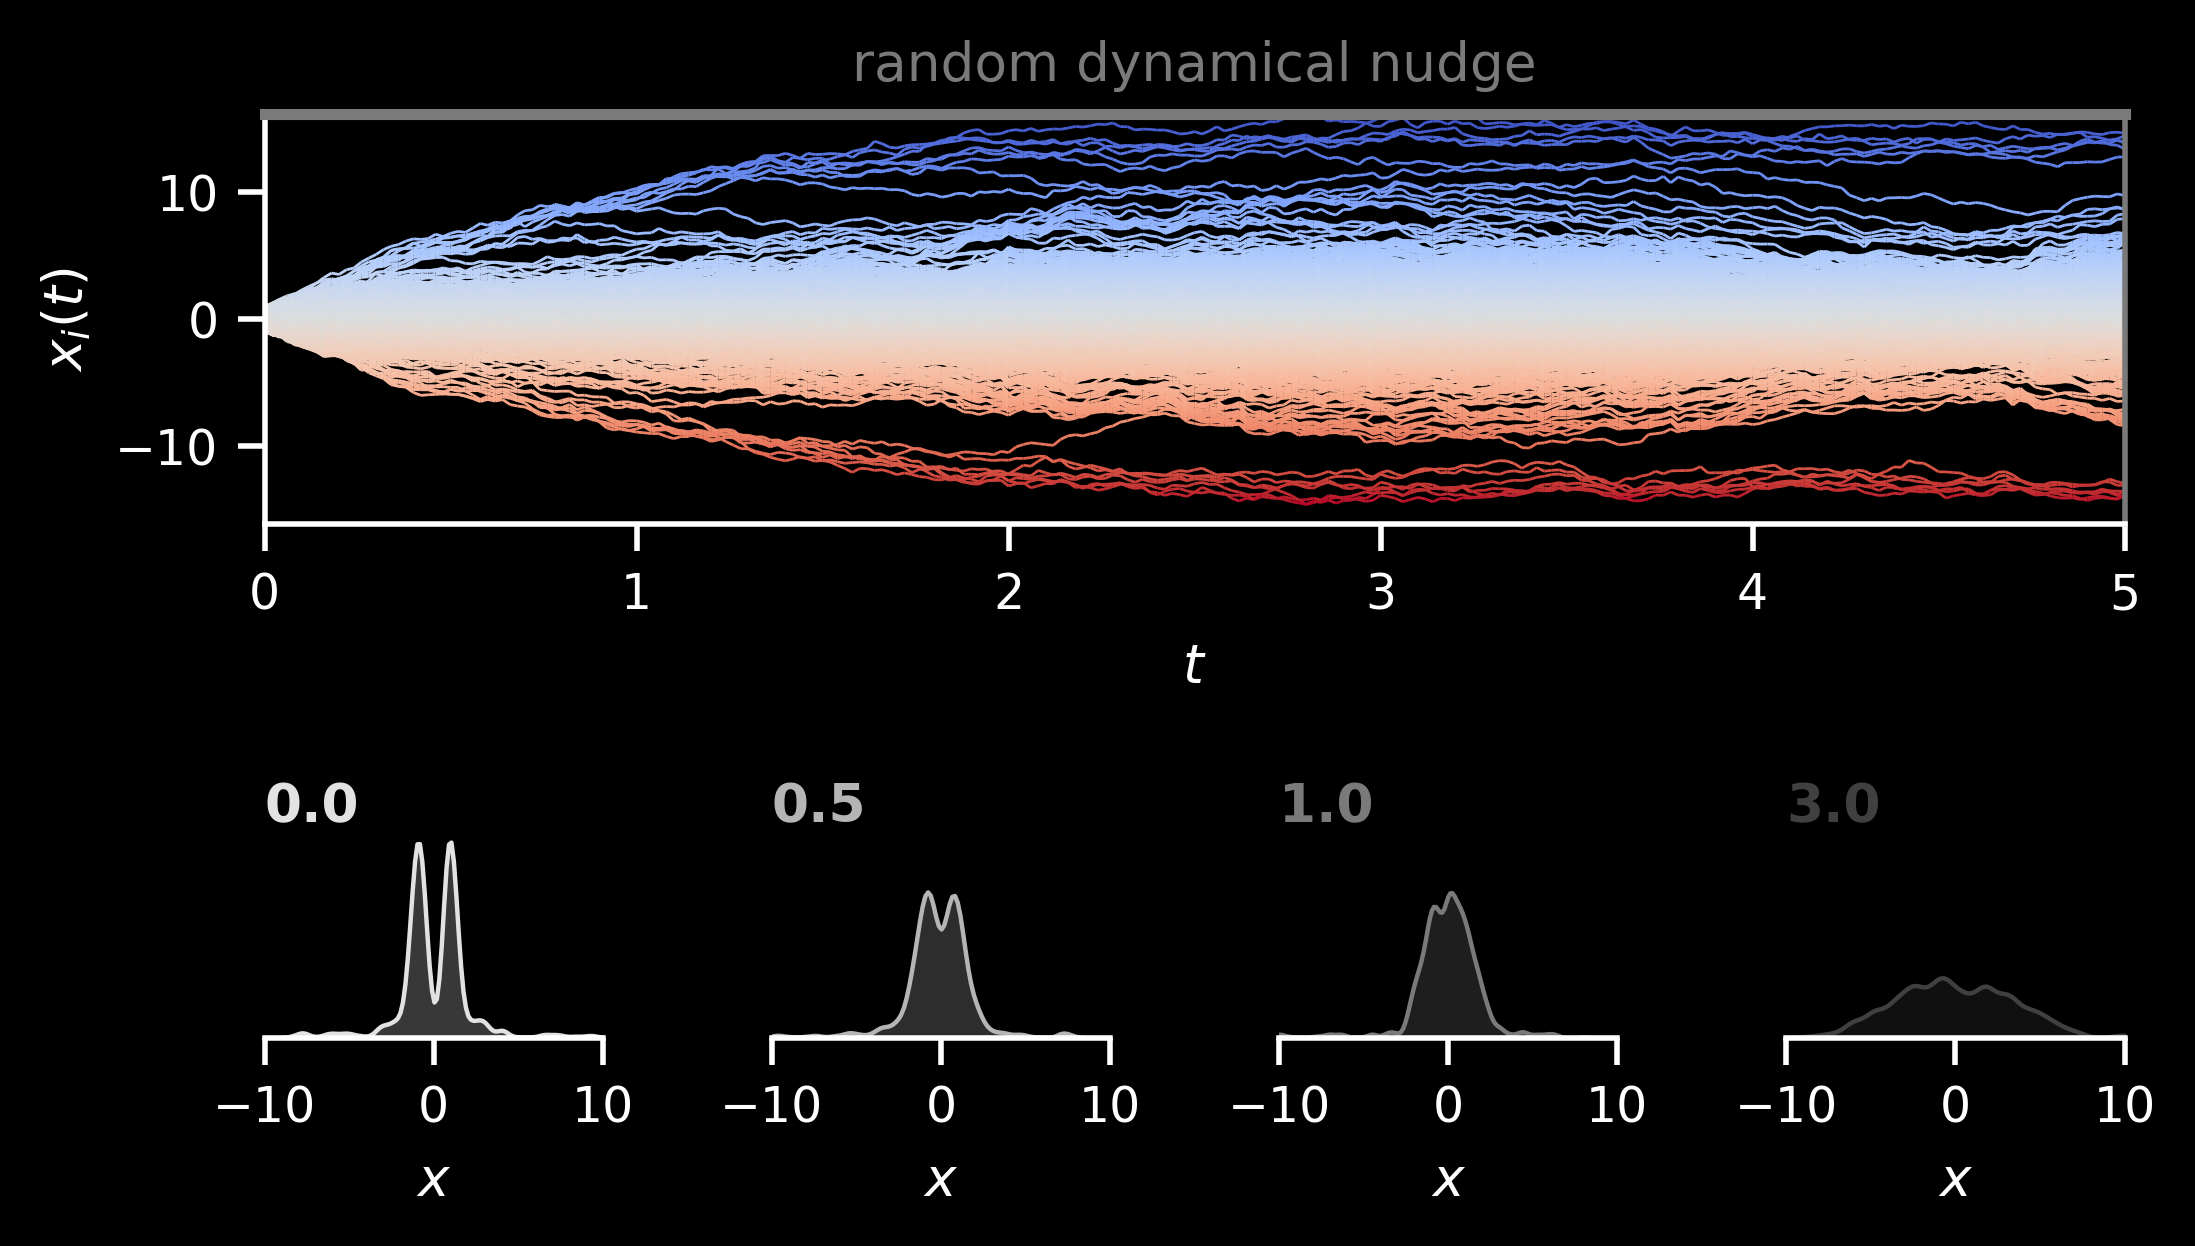

In [ ]:
# plot D
trace_kwargs = dict(color_code="line", subsample=2, lw=0.5, rasterized=True)

D_vals = [0.0, 0.5, 1.0, 3.0]
sns.reset_defaults()

with sns.plotting_context("paper"):
    plt.rcParams["axes.facecolor"] = "None"
    plt.style.use("dark_background")
    # create figure and grid
    fig = plt.figure(figsize=(6, 3), dpi=400)
 
    num_D = len(D_vals)
    gs_d = gridspec.GridSpec(
        2,
        num_D,
        hspace=1.,
        wspace=0.5,
        width_ratios=[1] * num_D,
        height_ratios=[2, 1],
    )

    # create axes
    ax_d_trace = fig.add_subplot(gs_d[0, :])
    ax_d = []
    for i in range(num_D):
        ax_d.append(
            fig.add_subplot(
                gs_d[1, i],
                sharey=ax_d[0] if i > 0 else None,
                sharex=ax_d[0] if i > 0 else None,
            )
        )

    # Make the grid look nice
    sns.despine(fig)

    D_colors = sns.color_palette("Greys", n_colors=num_D)

    kwargs = dict(
        N=1000,
        m=10,
        T=5,
        epsilon=1e-2,
        gamma=2.1,
        dt=0.01,
        K=3,
        beta=3,
        alpha=3,
        r=0.5,
    )

    chosen_D = 1.0
    sn_D = Simulation.run_params(
        cls=OpenChamber,
        D=chosen_D,
        cache="all",
        **kwargs,
    )
    vis_sn_D = VisSocialNetwork(sn_D)
    vis_sn_D.show_opinions(ax=ax_d_trace, **trace_kwargs)
    sns.despine(ax=ax_d_trace, top=False, right=False)

    d_color = D_colors[D_vals.index(chosen_D)]
    ax_d_trace.spines["top"].set_color(d_color)
    ax_d_trace.spines["right"].set_color(d_color)
    ax_d_trace.spines["top"].set_linewidth(2)
    ax_d_trace.set_title(
        "random dynamical nudge",
        color=d_color,
        # weight="bold"
    )

    for i, ax in enumerate(ax_d):
        df_d = (
            df_open[df_open["D"] == D_vals[i]]
            .to_pandas_df()
            .rename(columns={"opinion": OPINION_SYMBOL})
        )
        sns.kdeplot(
            data=df_d,
            x=OPINION_SYMBOL,
            color=D_colors[i],
            ax=ax,
            shade=True,
            bw_adjust=0.5,
        )

        ax.set(yticks=[], ylabel="")
        pop_dist = distribution_modality(df_d[OPINION_SYMBOL].values)
        y_max = ax.get_ylim()[1]
        # ax.annotate(
        #     f"{pop_dist:.2f}",
        #     xy=(0, y_max),
        #     xytext=(0, y_max * 1.05),
        #     arrowprops=dict(
        #         arrowstyle=f"-[,widthB={pop_dist}", color="k", alpha=0.7, lw=0.5
        #     ),
        #     alpha=0.8,
        #     fontsize="x-small",
        #     va="bottom",
        #     ha="center",
        # )

        # ax.annotate(
        #     PEAK_DISTANCE,
        #     xy=(0.5, 1),
        #     xycoords="axes fraction",
        #     va="bottom",
        #     ha="center",
        #     fontsize="small",
        # )
        ax.set_title(
            f"{D_vals[i]:.1f}",
            color=D_colors[i],
            # fontsize="large",
            loc="left",
            va="top",
            weight="bold",
        )
        sns.despine(ax=ax, left=True)
    ax_d[0].set_xlim(-10, 10)
fig.savefig("output/rdn.png", bbox_inches="tight")

In [ ]:
# @title Check `dt`

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)
kwargs = dict(
    N=1000,
    m=10,
    T=1,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.001,
    K=2,
    beta=1,
    alpha=3,
    r=0.65,
    cls=OpenChamber,
)
product_vars = {
    "D": {
        "range": [0, 1],
    },
    "dt": {"range": np.round(np.arange(0.001, 0.01 + 0.001, 0.001), 4)},
}
df_open_dt = Simulation.run_product(
    product_vars, parallel=True, plot_opinion=True, cache_sim="var_dt", **kwargs
)
sns.displot(data=df_open_dt.to_pandas_df(), x="opinion", col="D", hue="dt")

logging.getLogger().setLevel(logging_level)

In [ ]:
# @title α, β

kwargs = dict(
    N=1000,
    m=10,
    T=10,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=2,
    beta=1,
    alpha=3,
    r=0.65,
    cls=OpenChamber,
)

D_range = np.round(np.arange(0.0, 1.1, 0.1), 1)

parameters = {
    "D": {
        "range": D_range,
    },
    "beta": {
        "range": [0, 1, 2, 3],
        "title": "$\\beta$",
    },
    "alpha": {
        "range": [0.001, 1, 2, 3],
        "title": "$\\alpha$",
    },
}
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

df = Simulation.run_product(parameters, **kwargs)

logging.getLogger().setLevel(logging_level)

with sns.plotting_context("talk"):
    max_range = max([other["range"] for other in parameters.values()], key=len)
    fig, ax = plt.subplots(
        len(parameters), len(max_range), sharey=True, sharex=True, squeeze=False
    )
    fig.subplots_adjust(hspace=0.8)
    for i, (key, other) in enumerate(parameters.items()):
        show_noise_panel(df, key, kde_kwargs=dict(bw_adjust=0.1, cut=2), ax=ax[i])
        for _ax in ax[i]:
            _ax.set_title(f"{other['title']}={_ax.get_title()}")
            _ax.set_xlabel("")
            _ax.set(xlim=(-5, 5), ylim=(0, 1))

    sns.despine(fig=fig)
    for _ax in ax[-1]:
        _ax.set_xlabel(math_fix(f"${OPINION_SYMBOL}$"))
    fig.savefig(f"output/{list(parameters.keys())}_grid.svg")


### Delayed noise


In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(
    N=1000,
    m=10,
    activity_distribution=negpowerlaw,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.65,
    cls=OpenChamber,
)
D = 0.5

noise_start = 10.0
noise_length = 10.0
recovery = 10.0
num = 1
interval = 0
nsn = Simulation.run_periodic_noise(
    noise_start,
    noise_length,
    recovery,
    interval=interval,
    num=num,
    **kwargs,
    D=D,
    plot_opinion=True
)
# fig = plt.gcf()
# fig.savefig("output/delayed_noise.svg")
logging.getLogger().setLevel(logging_level)


### Generate figure 1

In [ ]:

from opdynamics.utils.plot_utils import move_cbar_label_to_title

run_p_opps = [0.1, 0.2, 0.5, 0.8, 0.9]
D_vals = [0.0, 0.5, 1.0, 3.0]
sns.reset_defaults()

with sns.plotting_context("paper"):
    plt.rcParams["axes.facecolor"] = "None"
    plt.style.use("dark_background")
    # create figure and grid
    fig = plt.figure(figsize=(7.2, 5), dpi=400)
    gs = gridspec.GridSpec(
        nrows=3,
        ncols=2,
        wspace=0.3,
        hspace=0.9,
        left=0.18,
        right=0.97,
        bottom=0.15,
        height_ratios=[1, 1.618, 1],
        width_ratios=[2, 1],
    )
    gs_traces = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec=gs[0, 0], hspace=0.2, wspace=0.2
    )

    gs_nn = gridspec.GridSpecFromSubplotSpec(
        2,
        4,
        subplot_spec=gs[1, 0],
        width_ratios=[1, 0.1, 1, 0.1],
        height_ratios=[0.1, 1],
        wspace=0.2,
        hspace=0.2,
    )

    gs_pop = gridspec.GridSpecFromSubplotSpec(
        len(run_p_opps), 1, subplot_spec=gs[:-1, -1], wspace=0.1, hspace=-0.25
    )

    num_D = len(D_vals)
    gs_d = gridspec.GridSpecFromSubplotSpec(
        1,
        1 + num_D,
        subplot_spec=gs[-1, :],
        hspace=0.2,
        width_ratios=[1] + [0.5] * num_D,
    )

    # create axes
    ax_trace_1 = fig.add_subplot(gs_traces[0, 0])
    ax_trace_2 = fig.add_subplot(gs_traces[0, 1])
    ax_joint = fig.add_subplot(gs_nn[1, 0])
    ax_marg_x = fig.add_subplot(gs_nn[0, 0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gs_nn[1, 1], sharey=ax_joint)

    ax_joint_rad = fig.add_subplot(gs_nn[1, -2])
    ax_marg_x_rad = fig.add_subplot(gs_nn[0, -2], sharex=ax_joint_rad)
    ax_marg_y_rad = fig.add_subplot(gs_nn[1, -1], sharey=ax_joint_rad)

    popp_axes = [fig.add_subplot(gs_pop[i, 0]) for i in range(len(run_p_opps))]

    ax_d_trace = fig.add_subplot(gs_d[0, 0])
    ax_d = []
    for i in range(num_D):
        ax_d.append(
            fig.add_subplot(
                gs_d[0, 1 + i],
                sharey=ax_d[0] if i > 0 else None,
                sharex=ax_d[0] if i > 0 else None,
            )
        )

    # Make the grid look nice
    sns.despine(fig)
    sns.despine(ax=ax_trace_1, right=False)  # keep right border
    sns.despine(ax=ax_trace_2, right=False)  # keep right border
    ax_trace_1.spines["right"].set_color("purple")
    ax_trace_2.spines["right"].set_color("red")
    sns.despine(ax=ax_marg_x, left=True)
    sns.despine(ax=ax_marg_y, bottom=True)
    sns.despine(ax=ax_marg_x_rad, left=True)
    sns.despine(ax=ax_marg_y_rad, bottom=True)
    # polarised opinions trace
    vis = VisSocialNetwork(ec_polar)
    trace_kwargs = dict(color_code="line", subsample=2, lw=0.5, rasterized=True)
    vis.show_opinions(ax=ax_trace_1, title="Polarized", **trace_kwargs)
    # nearest neighbour
    show_jointplot(
        ec_polar.opinions,
        ec_polar.get_nearest_neighbours(),
        ax=(ax_joint, ax_marg_x, ax_marg_y),
        marginal_kws=dict(bw_adjust=0.5),
    )

    # radicalised opinions trace
    vis_radical = VisSocialNetwork(ec_radical)
    vis_radical.show_opinions(ax=ax_trace_2, title="Radicalized", **trace_kwargs)
    show_jointplot(
        ec_radical.opinions,
        ec_radical.get_nearest_neighbours(),
        ax=(ax_joint_rad, ax_marg_x_rad, ax_marg_y_rad),
        cmap="Reds",
        marginal_kws=dict(color="red", bw_adjust=0.5),
    )
    ax_joint_rad.set_facecolor("#ffeee6")

    plot_p_opp_density(
        p_opp_df,
        run_p_opps=run_p_opps,
        betas=[3],
        axes=popp_axes,
        save="indv",
    )

    # plot D
    D_colors = sns.color_palette("Greys", n_colors=num_D)

    kwargs = dict(
        N=1000,
        m=10,
        T=5,
        epsilon=1e-2,
        gamma=2.1,
        dt=0.01,
        K=3,
        beta=3,
        alpha=3,
        r=0.5,
    )

    chosen_D = 1.0
    sn_D = Simulation.run_params(
        cls=OpenChamber,
        D=chosen_D,
        cache="all",
        **kwargs,
    )
    vis_sn_D = VisSocialNetwork(sn_D)
    vis_sn_D.show_opinions(ax=ax_d_trace, **trace_kwargs)
    sns.despine(ax=ax_d_trace, top=False, right=False)

    d_color = D_colors[D_vals.index(chosen_D)]
    ax_d_trace.spines["top"].set_color(d_color)
    ax_d_trace.spines["right"].set_color(d_color)
    ax_d_trace.spines["top"].set_linewidth(2)
    ax_d_trace.set_title(
        "random dynamical nudge",
        color=d_color,
        # weight="bold"
    )

    for i, ax in enumerate(ax_d):
        df_d = (
            df_open[df_open["D"] == D_vals[i]]
            .to_pandas_df()
            .rename(columns={"opinion": OPINION_SYMBOL})
        )
        sns.kdeplot(
            data=df_d,
            x=OPINION_SYMBOL,
            color=D_colors[i],
            ax=ax,
            shade=True,
            bw_adjust=0.5,
        )

        ax.set(yticks=[], ylabel="")
        pop_dist = distribution_modality(df_d[OPINION_SYMBOL].values)
        y_max = ax.get_ylim()[1]
        ax.annotate(
            f"{pop_dist:.2f}",
            xy=(0, y_max),
            xytext=(0, y_max * 1.05),
            arrowprops=dict(
                arrowstyle=f"-[,widthB={pop_dist}", color="k", alpha=0.7, lw=0.5
            ),
            alpha=0.8,
            fontsize="x-small",
            va="bottom",
            ha="center",
        )

        ax.annotate(
            PEAK_DISTANCE,
            xy=(0.5, 1),
            xycoords="axes fraction",
            va="bottom",
            ha="center",
            fontsize="small",
        )
        ax.set_title(
            f"{D_vals[i]:.1f}",
            color=D_colors[i],
            # fontsize="large",
            loc="left",
            va="top",
            weight="bold",
        )
        sns.despine(ax=ax, left=True)
    # cleaning
    ax_trace_1.set(xticks=[0, 5, 10], xlim=(0, 10))
    ax_trace_2.set(xticks=[0, 5, 10], xlim=(0, 10), ylabel="", yticklabels=[])

    for _ax_jnt in [ax_joint, ax_joint_rad]:
        _ax_jnt.set_xlim(-5, 5)
        _ax_jnt.set_ylim(-5, 5)
        _ax_jnt.set_xlabel(OPINION_SYMBOL)
        _ax_jnt.set_ylabel(MEAN_NEAREST_NEIGHBOUR)

    ax_joint_rad.set(yticklabels=[], ylabel="")

    for _ax in popp_axes:
        sns.despine(ax=_ax, left=True, bottom=True)

    ax_d[0].set_xlim(-5, 5)

    for letter, _ax in zip(
        string.ascii_lowercase,
        [ax_trace_1, ax_marg_x, ax_trace_2, ax_marg_x_rad, popp_axes[0], ax_d_trace],
    ):
        _ax.annotate(
            f"{letter}",
            xy=(0, 1),
            xycoords="axes fraction",
            xytext=(-27, 5),
            textcoords="offset points",
            fontsize="x-large",
            weight="bold",
            va="bottom",
            ha="right",
        )
    # reduce space between axes labels and axes
    # for _ax in flatten(fig.axes):
    #     _ax.yaxis.labelpad = 0
    #     _ax.xaxis.labelpad = 0

    fig.savefig("output/fig1.svg")


In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=400)
gs_nn = gridspec.GridSpec(
    nrows=2,
    ncols=4,
    width_ratios=[1, 0.1, 1, 0.1],
    height_ratios=[0.1, 1],
    wspace=0.2,
    hspace=0.2,
)

ax_joint = fig.add_subplot(gs_nn[1, -2])
ax_marg_x = fig.add_subplot(gs_nn[0, -2], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs_nn[1, -1], sharey=ax_joint)

ax_joint_rad = fig.add_subplot(gs_nn[1, 0])
ax_marg_x_rad = fig.add_subplot(gs_nn[0, 0], sharex=ax_joint_rad)
ax_marg_y_rad = fig.add_subplot(gs_nn[1, 1], sharey=ax_joint_rad)

# polarised opinions trace
# vis = VisSocialNetwork(ec_polar)
trace_kwargs = dict(color_code="line", subsample=2, lw=0.5, rasterized=True)
# vis.show_opinions(ax=ax_trace_1, title="Polarized", **trace_kwargs)
# nearest neighbour
show_jointplot(
    ec_polar.opinions,
    ec_polar.get_nearest_neighbours(),
    ax=(ax_joint, ax_marg_x, ax_marg_y),
    marginal_kws=dict(bw_adjust=0.5),
)

# radicalised opinions trace
# vis_radical = VisSocialNetwork(ec_radical)
# vis_radical.show_opinions(ax=ax_trace_2, title="Radicalized", **trace_kwargs)
show_jointplot(
    ec_radical.opinions,
    ec_radical.get_nearest_neighbours(),
    ax=(ax_joint_rad, ax_marg_x_rad, ax_marg_y_rad),
    cmap="Reds",
    marginal_kws=dict(color="red", bw_adjust=0.5),
)
ax_joint_rad.set_facecolor("#ffeee6")
for _ax_jnt in [ax_joint, ax_joint_rad]:
    _ax_jnt.set_xlim(-5, 5)
    _ax_jnt.set_ylim(-5, 5)
    _ax_jnt.set_xlabel(OPINION_SYMBOL)
    _ax_jnt.set_ylabel(MEAN_NEAREST_NEIGHBOUR)

ax_joint.set(yticklabels=[], ylabel="")
fig.savefig("output/nn.png", bbox_inches="tight")

## Activity vs Opinion

Polarised param set

- $r = 0.65$


> to reproduce the density in the papers, $10^3$ "opinion states" need to be plotted, with each opinion state consisting of 1000 agents' opinions.


In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# parameters
N = 1000
m = 10
T = 5
activity_distribution = negpowerlaw
epsilon = 1e-2
gamma = 2.1
dt = 0.01
r = 0.65

# how many simulations to run
try:
    from google.colab import drive

    num_states = 1000
except ModuleNotFoundError:
    num_states = 10
# where to save the file
file_name = ".cache/activity_vs_opinion.h5"

# helper array
agent_indices = np.arange(N, dtype=int)

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    states = hdf.keys()
    states_completed = len(states)
    # we start iterating from states_completed as the `seed` parameter uses `i`
    for i in tqdm(range(states_completed, num_states)):
        sn = Simulation.run_params(
            SocialNetwork,
            N=N,
            m=m,
            **param_set["polar"],
            activity=activity_distribution,
            epsilon=epsilon,
            gamma=gamma,
            r=r,
            dt=dt,
            T=T,
            cache=False,  # don't cache time portion
            seed=i,
        )
        # create dataframe for this iteration
        df = pd.DataFrame({"activity": sn.activities, "opinion": sn.opinions})
        # save to disk for use later
        hdf.append(f"d{i}", df)

# return to previous logging (more or less - we change root level)
logging.getLogger().setLevel(logging_level)

# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])

# plot everything
# (very good idea to rasterize for saving)
fig, ax, cbar = show_activity_vs_opinion(
    df_ao.opinion.values,
    df_ao.activity.values,
    bins=N,
    norm=LogNorm(vmin=1),
    cmap="Spectral_r",
    cbar_kws=dict(cax=True),
    s=0.1,
    rasterized=True,
)
ax.set_ylim(0, 0.5)
sns.despine()

# clear up some ram
del df_ao

fig.savefig("output/activity_vs_opinion.png", bbox_inches="tight")